<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

![](https://www.pennmedicine.org/news/-/media/images/pr%20news/news/2021/october/dna.ashx)

# Goals
In this notebook, you will:

*   Learn what feature reduction is and why it is important.
*   Learn about Lasso (L1) normalization, one of the most common methods of feature reduction.
*   Implement Lasso feature reduction into your own model and evaluate it.
*   Identify important mutations that can be used as biomarkers in determining where SARS-CoV-2 samples came from.
*  Learn the basics of Principal Components Analysis, a form of unsupervised learning, and apply it to your dataset.

***Note: This notebook covers some advanced topics typically taught in college-level Machine Learning courses. Don't worry if you don't understand the nitty gritty parts of the math. It is more important you understand general concepts, such as why feature reduction is important. Don't hesitate to ask your instructor any questions that come up!***

In [ ]:
#@title #### Set up the notebook
!pip install Biopython
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import seaborn as sns
from collections import Counter
from sklearn import model_selection, linear_model
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

# data_path = 'https://drive.google.com/uc?id=1f1CtRwSohB7uaAypn8iA4oqdXlD_xXL1'
# cov2_sequences = 'SARS_CoV_2_sequences_global.fasta'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20DNA%20Detectives/SARS_CoV_2_sequences_global.fasta'
cov2_sequences = 'SARS_CoV_2_sequences_global.fasta'



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 7.6 MB/s eta 0:00:00
SARS_CoV_2_sequence 100%[===================>]  44.77M   215MB/s    in 0.2s    


In [ ]:
#@title #### Load data from previous notebook (can take several minutes)
sequences = [r for r in SeqIO.parse(cov2_sequences, 'fasta')]
# This can take a couple minutes!
# Note: This can take a couple minutes to run!
# but we can monitor our progress using the tqdm library
mutation_df = pd.DataFrame()
n_bases_in_seq = len(sequences[0])

print("Creating feature matrix....")

feature_values_dict = {}
# Iterate though all positions in this sequence.
for location in (range(n_bases_in_seq)): # tqdm is a nice library that prints our progress.
  bases_at_location = np.array([s[location] for s in sequences])
  # If there are no mutations at this position, move on.
  if len(set(bases_at_location))==1: continue # If
  for base in ['A', 'T', 'G', 'C', '-']:
    feature_values = (bases_at_location==base)

    # Set the values of any base that equals 'N' to np.nan.
    feature_values[bases_at_location=='N'
                   ] = np.nan

    # Convert from T/F to 0/1.
    feature_values  = feature_values*1

    # Make the column name look like <location>_<base> (1_A, 2_G, 3_A, etc.)
    column_name = str(location) + '_' + base
    #mutation_df[column_name] = feature_values
    feature_values_dict[column_name] = feature_values
mutation_df = pd.concat([mutation_df, pd.DataFrame(feature_values_dict)], axis = 1)

print("Formatting labels....")
countries = [(s.description).split('|')[-1] for s in sequences]
countries_to_regions_dict = {
         'Australia': 'Oceania',
         'China': 'Asia',
         'Hong Kong': 'Asia',
         'India': 'Asia',
         'Nepal': 'Asia',
         'South Korea': 'Asia',
         'Sri Lanka': 'Asia',
         'Taiwan': 'Asia',
         'Thailand': 'Asia',
         'USA': 'North America',
         'Viet Nam': 'Asia'
}
regions = [countries_to_regions_dict[c] if c in
           countries_to_regions_dict else 'NA' for c in countries]
mutation_df['label'] = regions

print("Balancing data labels....")
balanced_df = mutation_df.copy()
balanced_df['label'] = regions
balanced_df = balanced_df[balanced_df.label!='NA']
balanced_df = balanced_df.drop_duplicates()
samples_north_america = balanced_df[balanced_df.label== ####### FILL IN ####
                                    'North America']
samples_oceania = balanced_df[balanced_df.label== ##### FILL IN #########
                              'Oceania']
samples_asia = balanced_df[balanced_df.label== ##### FILL IN #######
                           'Asia']

# Number of samples we will use from each region.
n = min(len(samples_north_america),
        len(samples_oceania),
        len(samples_asia))

balanced_df = pd.concat([samples_north_america[:n],
                    samples_asia[:n],
                    samples_oceania[:n]])

X = balanced_df.drop(columns = 'label')
Y = balanced_df.label


Creating feature matrix....
Formatting labels....
Balancing data labels....


In [ ]:
#@title #### Retrain previous model
lm = linear_model.LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)

# Split into training/testing set.
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    X, Y, train_size=.8, random_state=42)

# Train/fit model.
lm.fit(X_train, Y_train)

LogisticRegression(fit_intercept=False, max_iter=1000,
                   multi_class='multinomial', random_state=42, solver='saga',
                   tol=0.001)

In [ ]:
lm.classes_

array(['Asia', 'North America', 'Oceania'], dtype=object)

In [ ]:
lm.predict_proba(X_test)

array([[2.00190042e-02, 5.78164492e-05, 9.79923179e-01],
       [6.36392744e-01, 5.37537752e-03, 3.58231878e-01],
       [3.58715302e-02, 2.77605484e-03, 9.61352415e-01],
       [2.04446882e-02, 7.18275182e-04, 9.78837037e-01],
       [2.14361468e-02, 9.75928846e-01, 2.63500711e-03],
       [4.24861078e-01, 3.63320092e-03, 5.71505721e-01],
       [6.91206609e-01, 3.04936214e-01, 3.85717709e-03],
       [6.20528636e-05, 9.99936399e-01, 1.54836961e-06],
       [5.04978446e-01, 1.03412549e-01, 3.91609004e-01],
       [3.74396691e-01, 1.08125308e-02, 6.14790778e-01],
       [9.21338554e-01, 7.75890041e-02, 1.07244230e-03],
       [3.22313406e-02, 9.58266114e-01, 9.50254490e-03],
       [9.98483543e-01, 1.21575196e-03, 3.00704680e-04],
       [4.87368767e-02, 2.18912921e-02, 9.29371831e-01],
       [2.91216638e-02, 9.68273155e-01, 2.60518094e-03],
       [9.77812675e-01, 2.21262324e-02, 6.10927651e-05],
       [9.83460558e-01, 1.64421045e-02, 9.73375326e-05],
       [1.45087176e-03, 1.07830

# **Feature-reduced Models**

Even in regular logistic regression, features may or may not get used in a model. Recall the equation logistic regression is fitting:

$
Y = H(\beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + ...)
$

After training, if any $\beta$'s equal 0, that means the corresponding $x$ feature *did not get used in the model*.  ***The number of features used in the model equals the number of non-zero coefficients ($\beta$).***

We can access the values of the coefficients after training with ```lm.coef_[0]```.

### **Exercise: Recall your previous model. How many *features* did we use in the model?**

In [ ]:
coefficients = lm.coef_[0]
n_possible_features = len(coefficients)
n_features_used = sum(coefficients != 0)
print("The original logistic regression model used %i out of a possible %i features" %
      (n_features_used, n_possible_features))

The original logistic regression model used 4377 out of a possible 12680 features


Thousands of features is a lot of features! In feature-reduced models, we penalize the model for having more features. Hopefully then the model will pick only a few very important features to use.

In [ ]:
#@title ### **Exercise: Why might we want to try to *reduce* the number of features we use in a model?**
_1_ = "meow" #@param {type:"string"}
_2_ = "meow" #@param {type:"string"}

print("1. To prevent overfitting. Especially in models with more features than samples, ")
print("we can end up overfitting on the training set.\n")
print("2. In order to determine which features are the most important.")
print("In the case of SARS-CoV-2, we can use the important features as ")
print("biomarkers to determine which lineage came from which region.")

1. To prevent overfitting. Especially in models with more features than samples, 
we can end up overfitting on the training set.

2. In order to determine which features are the most important.
In the case of SARS-CoV-2, we can use the important features as 
biomarkers to determine which lineage came from which region.


### **Exercise: Compute training and testing accuracy to see if your original model was overfitting.**.

What does it mean if you're training accuracy is significantly higher than your testing accuracy?

In [ ]:
# Note that we have already loaded lm, X_test, X_train, Y_train, and Y_test for you!
Y_pred_train = lm.predict(X_train)
Y_pred_test = lm.predict(X_test)

training_accuracy = (np.mean(Y_train==Y_pred_train))*100
testing_accuracy = (np.mean(Y_test==Y_pred_test))*100
print("Training accuracy: %", training_accuracy)
print("Testing accuracy: %", testing_accuracy)

Training accuracy: % 99.3485342019544
Testing accuracy: % 90.9090909090909


## **The Lasso**

![alt text](https://pngimg.com/uploads/wonder_woman/wonder_woman_PNG30.png)


One way of reducing the feature space is to use a **Lasso** (or L1) penalty.

If a logistic regression model takes the form of

$
Y = H(\beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + ...)
$

Then a lasso penalty enforces a penalty that aims to make as many $\beta$ terms equal zero. After this penalty, the $x$ features that correspond to the non-zero $\beta$ terms left will be the most 'important' features in your model.

If you're interested in the math, we implement this by using a cost/loss function:

$
Loss = Cost(X, Y, \beta) + \lambda \sum_{i}|\beta_i|
$

Different values of $\lambda$ will make the model force more or less of the coefficients ($\beta$ values) to 0.

You can learn more [here](https://towardsdatascience.com/over-fitting-and-regularization-64d16100f45c) and [here](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c).

### Build a Lasso-Penalized Model
The ```linear_model.LogisticRegression``` class has an easy way to add in a Lasso penalty.

Add an argument ```penalty='l1'``` to tell the model to use a lasso penalty when training. Add an argument ```C=1/lam``` and pick a different value of ```lam``` to enforce a bigger or smaller penalty on the model for using coefficients.

```
l1m = linear_model.LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, C=c,
    penalty='l1', solver='saga', random_state=42)
```

### **Exercise: Investigate how different values of $\lambda$ affect the number of features in a model and its accuracy.**


In [ ]:
lam = 0.8 #@param {type:"slider", min:0, max:1, step:0.1}
l1m = linear_model.LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, C=1/lam,
    penalty='l1', solver='saga', random_state=42)
l1m.fit(X_train, Y_train)
print("Using lambda=", lam)
print("Lasso Training accuracy:", np.mean(Y_train==l1m.predict(X_train)))
print("Lasso Testing accuracy:", np.mean(Y_test==l1m.predict(X_test)))
print("Number of non-zero coefficients in lasso model:", sum(l1m.coef_[0]!=0))

Using lambda= 0.8
Lasso Training accuracy: 0.9674267100977199
Lasso Testing accuracy: 0.9090909090909091
Number of non-zero coefficients in lasso model: 113


## **Cross Validation**

We can use a method called cross validation to decide what the best value of $\lambda$ is. In cross validation, we split the training set into a training and validation set. We train the model using different values of $\lambda$ (or $C$) and evaluate the accuracy using the training set. We do this using $K$ different iterations of testing/validation split. Then we choose the value of $\lambda$ that has the best average accuracy for the final output of the training. K-fold cross validation is also better for evaluating a model's accuracy, since every sample in the dataset will be part of the training and testing set at some iteration in the k-fold cross validation process.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/1280px-K-fold_cross_validation_EN.svg.png" alt="drawing" width="500"/>

Instead of specifying ```C=1/lam``` in our arguments to the ```LogisticRegression``` class, we can use ```LogisticRegressionCV``` class the argument ```cv=``` and set the number of C (or 1/$\lambda$) values we wish for the model to go through.

```
lm_cv = linear_model.LogisticRegressionCV(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001,
    solver='saga', random_state=42,
    Cs=3, penalty='l1')
```

### **Exercise: Implement cross-validation to the logistic regression model and compute accuracy.**

Note: Sometimes you can get unlucky with the randomly selected validation sets, and cross validation won't improve your model. **Note that this will take several minutes.**

In [ ]:
lm_cv = linear_model.LogisticRegressionCV(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001,
    solver='saga', random_state=42, refit=False,
    Cs=5, penalty='l1'
    )

lm_cv.fit(X_train, Y_train)
print("Training accuracy:", np.mean(Y_train==lm_cv.predict(X_train)))
print("Testing accuracy:", np.mean(Y_test==lm_cv.predict(X_test)))
print("Number of non-zero coefficients in lasso model:", sum(lm_cv.coef_[0]!=0))
print("Lambda decided on by cross validation:", 1/lm_cv.C_[0])

Training accuracy: 0.9576547231270358
Testing accuracy: 0.9090909090909091
Number of non-zero coefficients in lasso model: 3638
Lambda decided on by cross validation: 0.04807692307692307


# **Bonus Section: Unsupervised Learning**

Although we have focused on supervised machine learning in this class, biology and genomics often uses a lot of unsupervised learning.

Unsupervised learning is another way to reduce the number of features in a dataset. Instead of throwing out features, we create new features that are linear combinations of the original features.

<img src="https://www.researchgate.net/publication/351953193/figure/fig3/AS:11431281117150742@1675395484096/Supervised-and-unsupervised-machine-learning-a-Schematic-representation-of-an.png" alt="drawing" width="500"/>

For example, say we have a dataset with features ```arm length```, ```leg length```, ```sprint speed```, and ```mile speed```.

|Name |Arm Length |Leg Length | Sprint Speed| Km Speed|
|--|--|--|--|--|
|Jocelyn|89cm|104cm|30kph|20kph|
|Aisha|99cm |120cm|29kph|19kph|
|Su Lin| 90cm|106cm|26kph|18kph|
|Marissa|100cm|122cm|29kph|20kph|

Principal component analysis (PCA) is a method that allows us to find linear combinations of features that spreads the data furthest apart on a lower dimensional grid.

If we used PCA to reduce the feature space into 2 features (instead of 4), PCA might tell us that the best new features to use would be:

|Name |Arm + Leg Length |Sprint Speed + Km Speed|
|--|--|--|
|Jocelyn|193cm|50kph
|Aisha|219cm|48kph|
|Su Lin|196cm|44kph|
|Marissa|222cm|39kph|



Read [this article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and play around with the widget to learn more about PCA!


In biology, we normally use unsupervised learning as a way to visualize data that is high-dimensional (large # of features) in a 2-dimensional grid. We can then look for data points that are grouped together, and make a hypothesis that those datapoints have similar biological properties.

## Visualize your data in principle component space

We can use ```sklearn```'s ```decomposition.PCA``` class to compute the principle components of a dataset and visualize it.

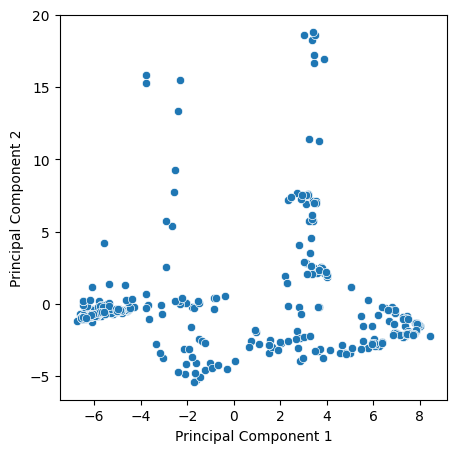

In [ ]:
#@title ### **Exercise: Run the following to visualize our X dataset in principal component space.**
data = mutation_df#[variant_df.regions=='USA']
pca = decomposition.PCA(n_components=2)
pca.fit(X)
df = pd.DataFrame()
df['Principal Component 1'] = [pc[0] for pc in pca.transform(X)]
df['Principal Component 2'] = [pc[1] for pc in pca.transform(X)]
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, x='Principal Component 1', y='Principal Component 2')
plt.show()

In [ ]:
# @title ### **Exercise: Why do you think this is called unsupervised learning?**
Response = "We don't set the relationships for the computer" #@param {type:"string"}
print("We are able to make obsevations about the data without ever using any sort of label.")
print("We can see that there are clusters of very similar samples.  ")
print("We should suspect data points near each other are probably viruses ")
print("from similar regions of the world, or that these viruses have similar biological properties.")

We are able to make obsevations about the data without ever using any sort of label.
We can see that there are clusters of very similar samples.  
We should suspect data points near each other are probably viruses 
from similar regions of the world, or that these viruses have similar biological properties.


*Hint: Look at the hidden code. Did we ever use ```Y```?*

Just for fun, we are going to now color the data points on our PCA plot to see if points that are similar in PC space are from similar regions of the world. Run the cell below to do so.

<Axes: xlabel='Principal Component 1', ylabel='Principal Component 2'>

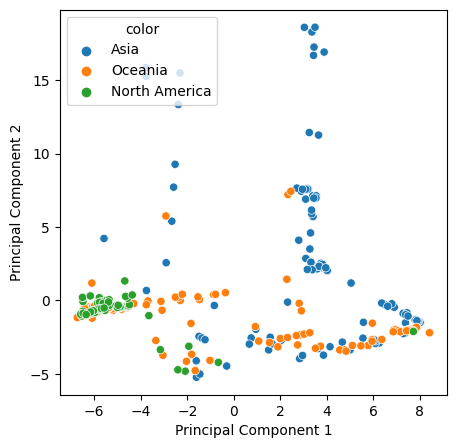

In [ ]:
#@title ### **Exercise: Color the data points by region**
df['color'] = Y
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, x='Principal Component 1', y='Principal Component 2', hue='color')

In [ ]:
# @title ### **Exercise: Based on your observations about the PCA plot, can you hypothesize why our classifier wasn't 100% accurate?**
Hypothesis = "not enough features" #@param {type:"string"}

# Wrapping things up

**Amazing job!!**  What we went over today is normally taught in a sophomore level college course.

<a href="https://imgflip.com/i/424k4k"><img src="https://i.imgflip.com/424k4k.jpg" title="made at imgflip.com"/></a>

To synthesize what we learned today, complete the following exercise.


In [ ]:
#@title ### **Exercise: What other machine learning problems that we did in this course do you think would benefit from these advanced feature reduction techniques?**
_1_ = "" #@param {type:"string"}
_2_ = "" #@param {type:"string"}
